In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import scipy.signal
import radarkit
import matplotlib
import matplotlib.pyplot as plt
import time

In [3]:
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Arial', 'Helvetica']
matplotlib.rcParams['font.sans-serif'] = ['System Font', 'Verdana', 'Arial']
matplotlib.rcParams['figure.figsize'] = (8.89, 5)   # Change the size of plots
matplotlib.rcParams['figure.dpi'] = 144

In [4]:
sweep = radarkit.read('/Users/boonleng/Downloads/PX-20170220-050706-E2.4-Z.nc')

z = sweep['moments'][0]['data']
p = sweep['moments'][4]['data']
r = sweep['moments'][5]['data']

In [5]:
st = 3                                 # SNR threshold
rt = 0.85                              # RhoHV threshold
vt = 20.0                              # Threshold of local variance of delta Phi
alpha = np.arange(0.01, 0.51, 0.01)    # Search space of alpha values

In [6]:
ia = np.arange(p.shape[0])
zl = 10.0 ** (0.1 * z)
zl[np.isnan(z)] = 0.0

In [7]:
gateCount = z.shape[1]
gateSpacing = 1.0e-3 * sweep['gateSizeMeters']
downSamplingRatio = int(sweep['gateSizeMeters'] / 30.0)

# Undo range correction and the ZCal in DSP to estimate the SNR
rr = 1.0e-3 * (np.arange(sweep['gateCount']) + 0.5) * sweep['gateSizeMeters']
snr = z - 20.0 * np.log10(rr) + 23

# Transition gate at 10.5 km at the given spacing
g = int((69.0e-6 * 3.0e8 * 0.5) / 30.0) + 5
g = int((g + downSamplingRatio - 1) / downSamplingRatio)

print(g)

z_off = 10.0 * np.log10(1.5 / 67)
snr[:, :g] = snr[:, :g] + z_off

# PhiDP calibration so that the transition is smooth and PhiDP starts ~ 0 deg
p[:, :g] = p[:, :g] + 40;
p[:, g:] = p[:, g:] + 44;

88


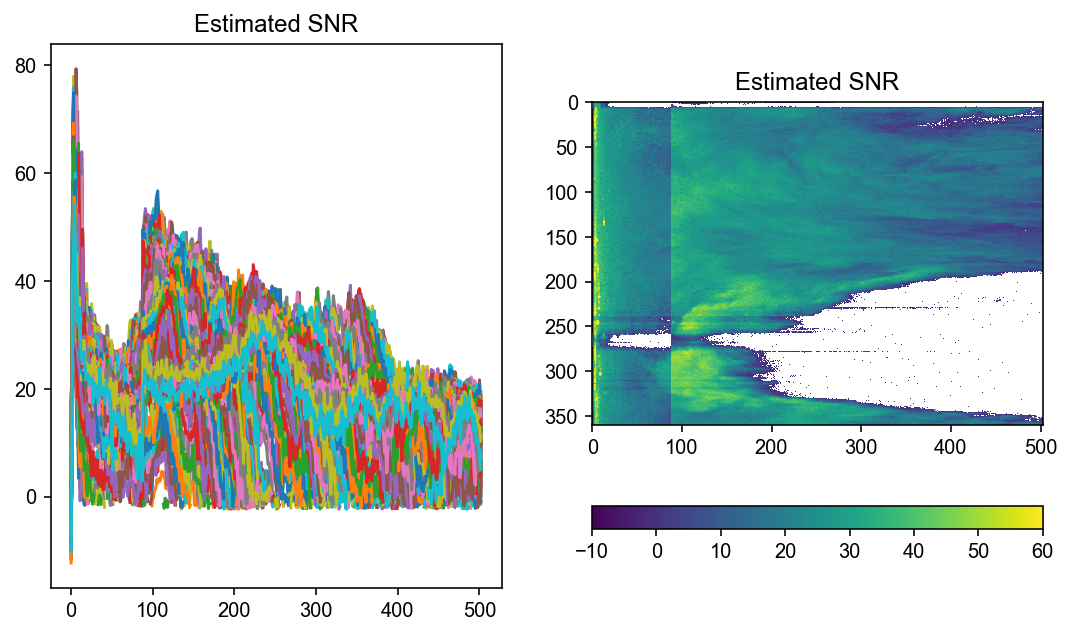

In [8]:
# hl = plt.plot(snr.T[g-20:g+20, :])
plt.figure()

plt.subplot(121)
_ = plt.plot(snr.T)
plt.title('Estimated SNR')

plt.subplot(122)
plt.imshow(snr)
plt.clim(-10, 60)
plt.colorbar(orientation='horizontal')
_ = plt.title('Estimated SNR')

### Fast Code

```python
s = time.time()
for _ in range(10):
    
    mask = np.logical_and(snr>0, r>0.85)

e = time.time()
print(e - s)
```

### Naive Code

```python
s = time.time()
for _ in range(10):
    
    mask = np.zeros(snr.shape, dtype=bool)
    for j in range(snr.shape[0]):
        for i in range(snr.shape[1]):
            if (snr[j, i] > 0 and r[j, i] > 0.85):
                mask[j, i] = True

e = time.time()
print(e - s)
```

In [9]:
# Quality mask
mq = np.logical_and(np.nan_to_num(snr) > st, np.nan_to_num(r) > rt)

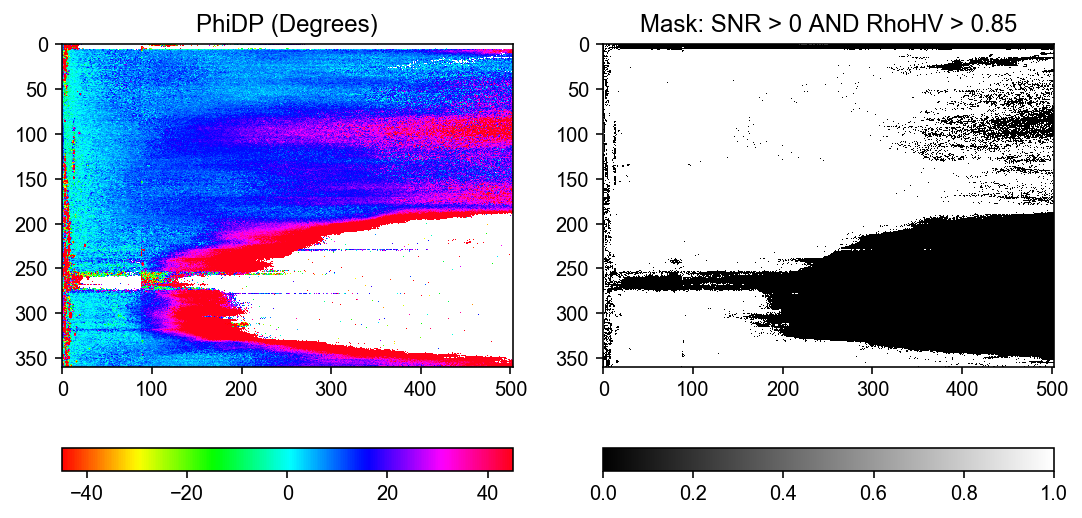

In [10]:
plt.figure()

plt.subplot(121)
plt.imshow(p, cmap=matplotlib.cm.hsv)
plt.clim(-45, 45)
plt.title('PhiDP (Degrees)')
plt.colorbar(orientation='horizontal')

plt.subplot(122)
plt.imshow(mq, cmap=matplotlib.cm.gray)
plt.clim(0, 1)
plt.title('Mask: SNR > 0 AND RhoHV > 0.85')
plt.colorbar(orientation='horizontal')

In [11]:
# w = 10
# r0 = np.zeros(p.shape[0])
# for i in range(p.shape[0]):
#     for g in range(p.shape[1] - w):
#         kern = pm[i, g:g+w]
#         if np.std(kern) < 10.0 and np.mean(np.diff(kern)) > 0.1:
#             r0[i] = i
#             break

In [12]:
# pp = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
# ww = np.ones(2) / 2.0
# sp.signal.lfilter(ww, 1.0, pp)

In [13]:
# A copy of PhiDP with NAN set to 0.0
pz = np.nan_to_num(np.copy(p))

# Smoothing
w = 20
ww = np.ones(w) / w;
ps = sp.signal.lfilter(ww, 1.0, pz)

# Compute local variance
p_var = sp.signal.lfilter(ww, 1.0, pz ** 2) - ps ** 2
p_var[~mq] = 100.0

# Compute local slope
p_slope = sp.signal.lfilter(ww, 1.0, np.diff(p))

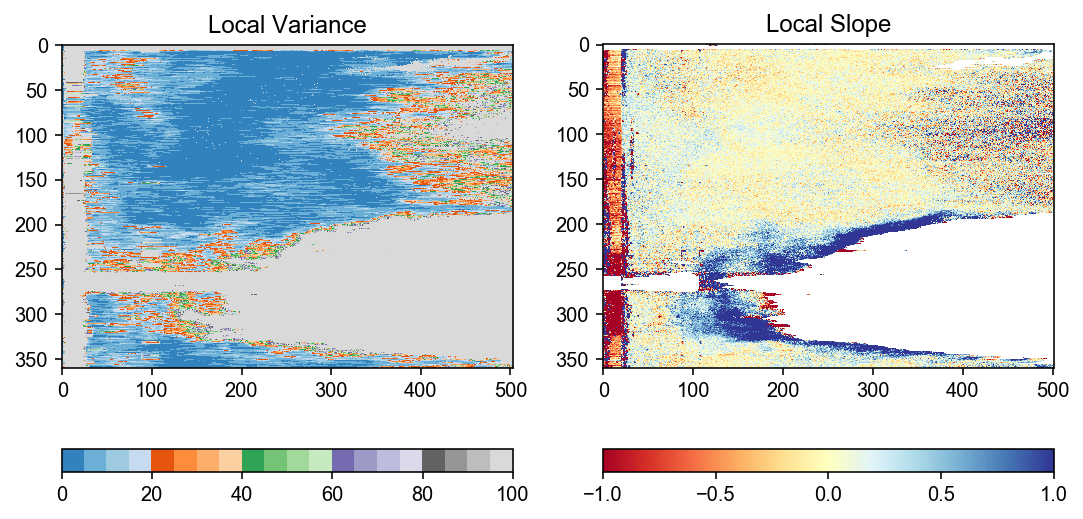

In [14]:
plt.figure()

plt.subplot(121)
plt.imshow(p_var, cmap=matplotlib.cm.tab20c)
plt.clim(0.0, 100.0)
plt.title('Local Variance')
plt.colorbar(orientation='horizontal')

plt.subplot(122)
plt.imshow(p_slope, cmap=matplotlib.cm.RdYlBu)
plt.clim(-1.0, 1.0)
plt.title('Local Slope')
plt.colorbar(orientation='horizontal')

In [15]:
# Statistical mask
ms = np.logical_and(mq, p_var < vt)
ms[:, :-1] = np.logical_and(ms[:, :-1], np.abs(np.nan_to_num(p_slope, 0.0)) < 0.5)
ms_count = np.sum(ms, axis=1)

g = 20;

# Data bounds
r0 = np.argmax(ms[:, g:], axis=1) + g
rm = p.shape[1] - np.argmax(ms[:, :g:-1], axis=1) - 1

# X-band
b = 1.02

alpha_count = len(alpha)

# Construct the index path to use PhiDP
paths = []
ah = np.zeros((*ps.shape, alpha_count))
edge = np.zeros(ms.shape, dtype=bool)
deltaPhi = np.zeros(ps.shape[0])
for i, s, e, c in zip(ia, r0, rm, ms_count):
    if c > 50:
        # Only use the path index if the length > 50 cells
        edge[i, s:e] = True;
        paths.append((i, s, e))
        deltaPhi[i] = ps[i, e] - ps[i, s]

# Mask out the Z and smoothed PhiDP values outside (r0, rm)
zl[~edge] = 0.0
ps[~edge] = np.nan

# Z ** b
zb = zl ** b;

# I(r; rm) is a function of r, integrate Z from r to rm
ir = 0.46 * b * np.cumsum(zb[:, ::-1], axis=1)[:, ::-1] * gateSpacing
ir0 = np.array([x[i] for x, i in zip(ir, r0)])

In [16]:
# plt.subplot(121)
# plt.imshow(np.log10(zl))

# plt.subplot(122)
# plt.imshow(np.log10(ir))

In [17]:
# The common term in size of (360, 1, alpha_count)
tenPowerSomethingMinusOne = 10.0 ** (0.1 * b * np.outer(deltaPhi, alpha).reshape((ps.shape[0], 1, -1)))

In [18]:
# Repeat Z for all combinations of r and alpha
zb_big = np.repeat(np.expand_dims(zb, 2), alpha_count, axis=2)
ir_big = np.repeat(np.expand_dims(ir, 2), alpha_count, axis=2)
ps_big = np.repeat(np.expand_dims(ps, 2), alpha_count, axis=2)

# I(r0; rm) is the same for one ray, all gates, all alpha values
ir0_big = np.repeat(ir0, ps.shape[1] * alpha_count).reshape((*ps.shape, alpha_count))

# Eq (15) for all (r; rm) so that ir[x] = 0.46 b int_x^rm (z ** b) dr
num = zb_big * tenPowerSomethingMinusOne
den = (ir0_big + tenPowerSomethingMinusOne * ir_big)
mv = den == 0.0
num[mv] = 0.0
den[mv] = 1.0
ah_big = num / den

# Construct PhiDP for all alpha values
alpha_big = np.outer(np.ones(ps.shape), alpha).reshape((*ps.shape, alpha_count))
pc_big = 2.0 * np.cumsum(ah_big, axis=1) / alpha_big * gateSpacing

In [19]:
# Pick the best alpha
ps_big = np.nan_to_num(ps_big)
pc_big = np.nan_to_num(pc_big)

err = np.sum(np.abs(ps_big - pc_big), axis=(0, 1))

alpha_idx = np.argmin(err)

pc = pc_big[:, :, alpha_idx]
pc[~edge] = np.nan

print('Best alpha @ {} / {} -> {:.4f}'.format(alpha_idx, alpha_count, alpha[alpha_idx]))

Best alpha @ 31 / 50 -> 0.3200


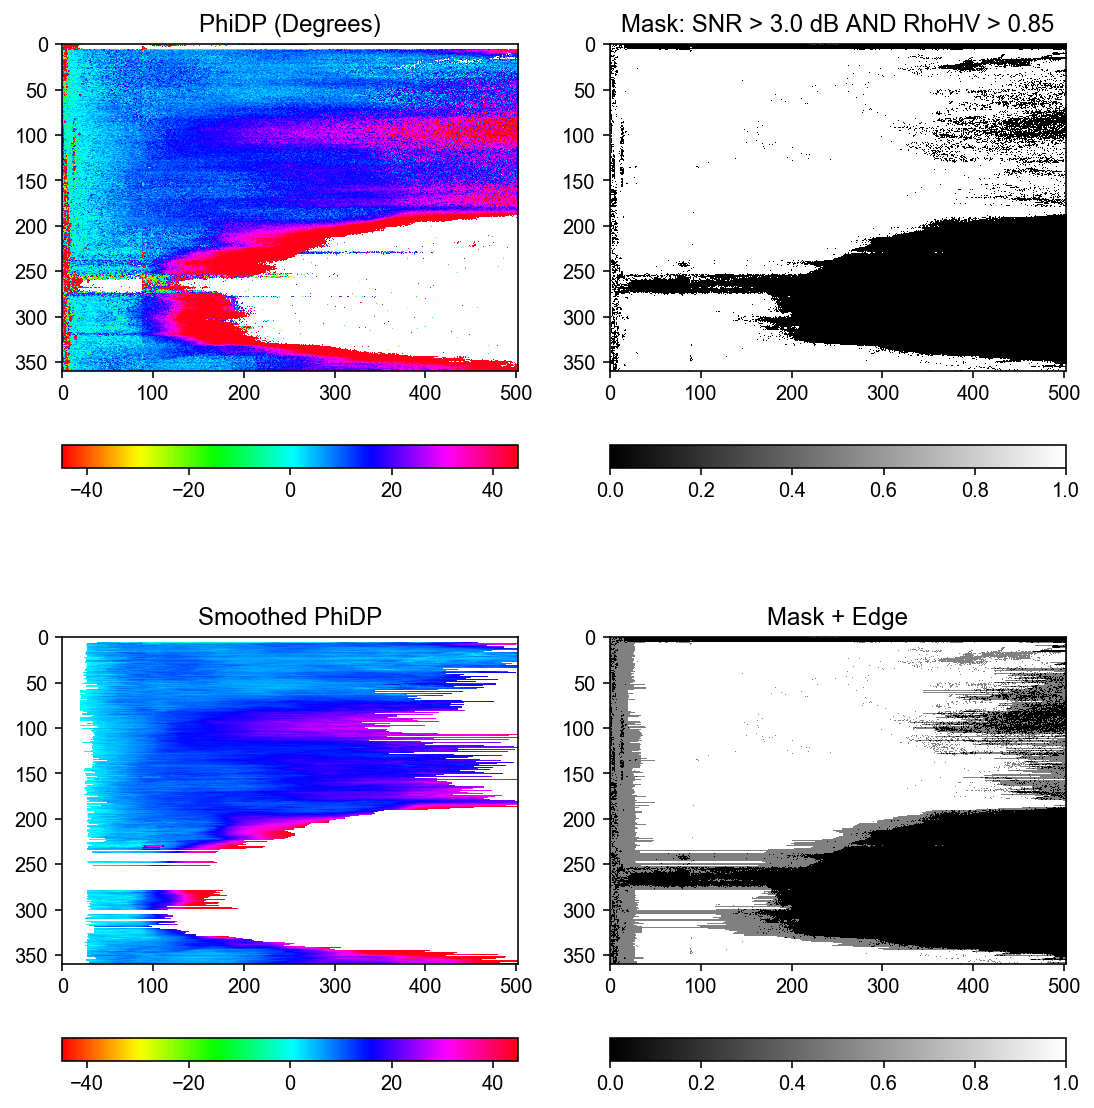

In [20]:
plt.figure(figsize=(9, 10))

plt.subplot(221)
plt.imshow(p, cmap=matplotlib.cm.hsv)
plt.clim(-45, 45)
plt.title('PhiDP (Degrees)')
plt.colorbar(orientation='horizontal')

plt.subplot(222)
plt.imshow(mq, cmap=matplotlib.cm.gray)
plt.clim(0, 1)
plt.title('Mask: SNR > {:.1f} dB AND RhoHV > {:.2f}'.format(st, rt))
plt.colorbar(orientation='horizontal')

plt.subplot(223)
plt.imshow(ps, cmap=matplotlib.cm.hsv)
plt.clim(-45, 45)
plt.title('Smoothed PhiDP')
plt.colorbar(orientation='horizontal')

plt.subplot(224)
# plt.imshow(0.5 * (np.array(ms, dtype=np.int) + edge), cmap=matplotlib.cm.gray)
plt.imshow(0.5 * (np.array(mq, dtype=np.int) + edge), cmap=matplotlib.cm.gray)
plt.clim(0, 1)
plt.title('Mask + Edge')
plt.colorbar(orientation='horizontal')

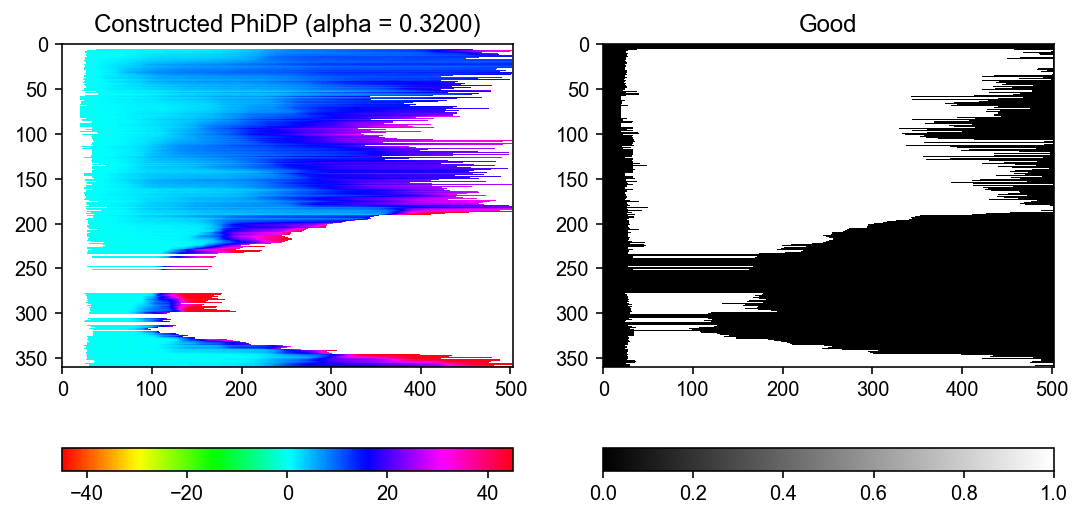

In [21]:
plt.figure()

plt.subplot(121)
plt.imshow(pc, cmap=matplotlib.cm.hsv)
plt.clim(-45, 45)
plt.title('Constructed PhiDP (alpha = {:.4f})'.format(alpha[alpha_idx]))
plt.colorbar(orientation='horizontal')

plt.subplot(122)
plt.imshow(edge, cmap=matplotlib.cm.gray)
plt.clim(0, 1)
plt.title('Good')
plt.colorbar(orientation='horizontal')

In [66]:
# at = 2.0 * np.cumsum(ah_big[:, :, alpha_idx], axis=1) * gateSpacing

# Use good PhiDP values
# mp = np.logical_or(~ms, pz <= 0.0)
# pz[mp] = 0.0
# mp = pz <= 0.0

pp = np.copy(p)
mp = np.nan_to_num(pp) <= 0.0

pp[mp] = 0.0

at = alpha[alpha_idx] * pp ** b
# at[mp] = 0.0

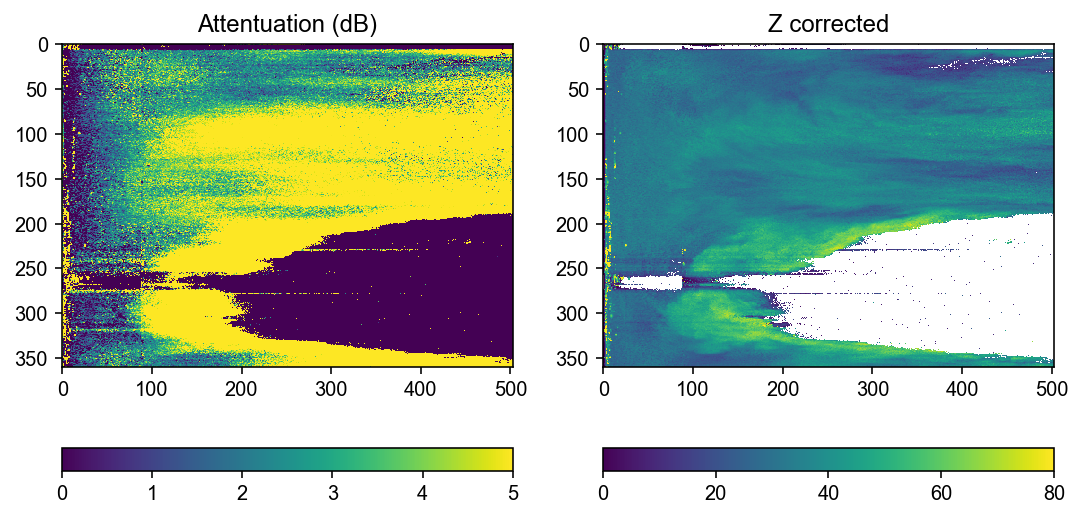

In [67]:
plt.figure()

plt.subplot(121)
plt.imshow(at)
plt.clim(0, 5)
plt.title('Attentuation (dB)')
plt.colorbar(orientation='horizontal')

plt.subplot(122)
plt.imshow(z + at)
plt.clim(0, 80)
plt.title('Z corrected')
plt.colorbar(orientation='horizontal')

In [81]:
zc = z + at - 5.0;

In [82]:
import chart

In [83]:
# Original range (km) and zimuth (rad) of the data
r, a = np.meshgrid(1.0e-3 * sweep['range'], sweep['azimuth'] * (np.pi / 180.0))

# Cartesian coordinate of the radar cells
x = r * np.sin(a)
y = r * np.cos(a)

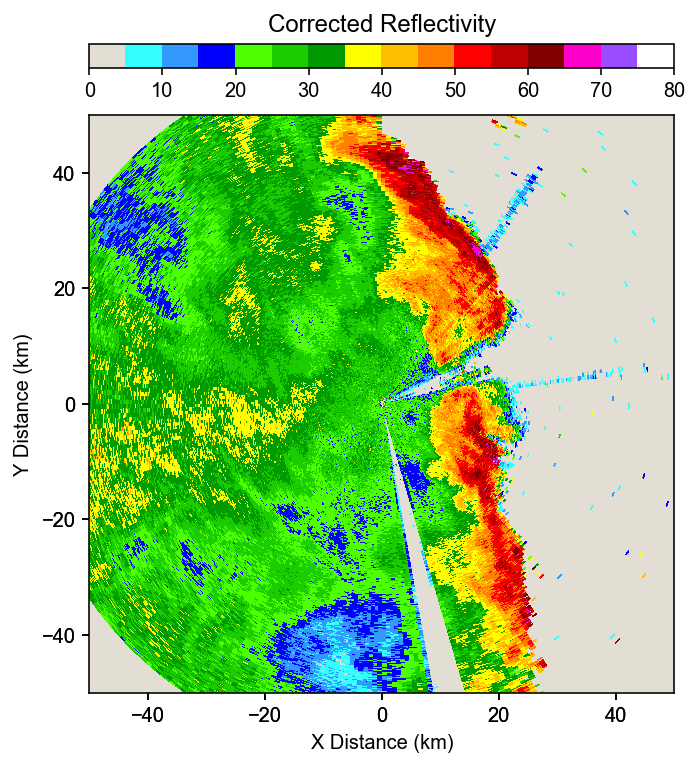

In [84]:
ppi = chart.showPPI(x, y, zc, title='Corrected Reflectivity', maxrange=50.0)

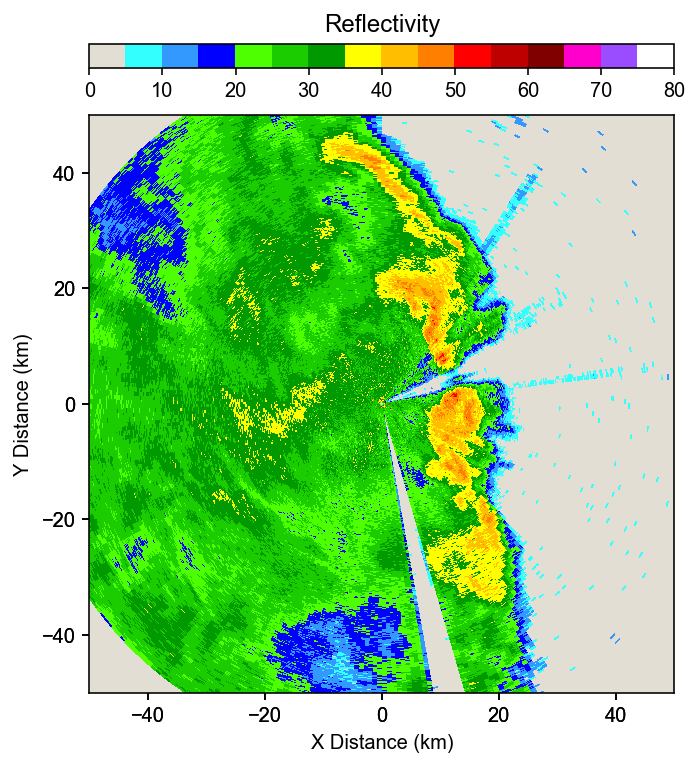

In [80]:
ppi = chart.showPPI(x, y, z, title='Reflectivity', maxrange=50.0)